In [1]:
import os
import xarray as xr

from tqdm import tqdm
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature

# import numpy as np
# import pandas as pd
# import geopandas as gpd

# from joblib import Parallel, delayed

# import sys
# import pickle

# import time as tm
# import datetime as dt
# from datetime import datetime, timedelta

# from matplotlib.gridspec import GridSpec
# from matplotlib.patches import Rectangle

# from shapely.geometry import Point, shape, Polygon


## Plot regional statistical plots

In [34]:
plot_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_stats_maps/'

for region in range(0, 35):
    # Compute the mean through time
    weekly_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_files/'
    weekly_ds = xr.open_dataset(os.path.join(weekly_fp, f'ds_weekly_file_region_{str(region).zfill(2)}.nc'))
    mean_ds = weekly_ds.mean(dim='time')
    weekly_ds.close()

    stats_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_stats/'
    stats_ds = xr.open_dataset(os.path.join(stats_fp, f'trendline_weekly_region_{str(region).zfill(2)}.nc'))

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20), dpi=300, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
    fig.suptitle(f"Region {region}", fontsize=42)

    # Plot 'mean'
    mean_ds['chlor_a'].plot(ax=axs[0, 0], transform=ccrs.PlateCarree(), cmap='turbo', cbar_kwargs={'label': 'mg/m3'}, vmin=0, vmax=3.5)
    axs[0, 0].coastlines()
    axs[0, 0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
    axs[0, 0].set_title('Mean Chlorophyll-a Concentration', fontsize=24)

    # Plot 'slope'
    stats_ds['slope'].plot(ax=axs[0, 1], transform=ccrs.PlateCarree(), cmap='seismic', cbar_kwargs={'label': 'mg/m3/week'}, vmin = -.0025, vmax = .0025)
    axs[0, 1].coastlines()
    axs[0, 1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white') 
    axs[0, 1].set_title('Chlorophyll-a Trend', fontsize=24)

    # Plot 'numpts'
    stats_ds['numpts'].plot(ax=axs[1, 0], transform=ccrs.PlateCarree(), cmap='turbo', vmin = 0, vmax = 1000, cbar_kwargs={'label': 'Valid Points'})
    axs[1, 0].coastlines()
    axs[1, 0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
    axs[1, 0].set_title('Number of Data Points', fontsize=24)

    # Plot 'stderr'
    stats_ds['stderr'].plot(ax=axs[1, 1], transform=ccrs.PlateCarree(), cmap='Reds', cbar_kwargs={'label': 'mg/m3'}, vmin = 0, vmax = 1)
    axs[1, 1].coastlines()
    axs[1, 1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
    axs[1, 1].set_title('Standard Error of the Trend', fontsize=24)

    # Save the figure
    plt.savefig(os.path.join(plot_output , f'trendline_region_{str(region).zfill(2)}.png'))

    plt.close()
    stats_ds.close()

## Combine weekly means into pan-GL file

In [30]:
plot_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_stats_maps/'
mean_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_mean_files'
if not os.path.exists(mean_output):
    os.makedirs(mean_output)

datasets = []
for region in range(0, 35):
    print(f"Working on region {region}")
    # Compute the mean through time
    weekly_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_files/'
    weekly_ds = xr.open_dataset(os.path.join(weekly_fp, f'ds_weekly_file_region_{str(region).zfill(2)}.nc'))
    mean_ds = weekly_ds.mean(dim='time')
    weekly_ds.close()
    
    mean_ds.to_netcdf(os.path.join(mean_output, f'mean_weekly_region_{str(region).zfill(2)}.nc'))
    datasets.append(mean_ds)
    
    mean_ds.close()

# Combine all the datasets into one
combined_ds = xr.concat(datasets, dim='region')
combined_ds.to_netcdf(os.path.join(mean_output, 'mean_weekly_all_regions.nc'))
combined_ds.close()


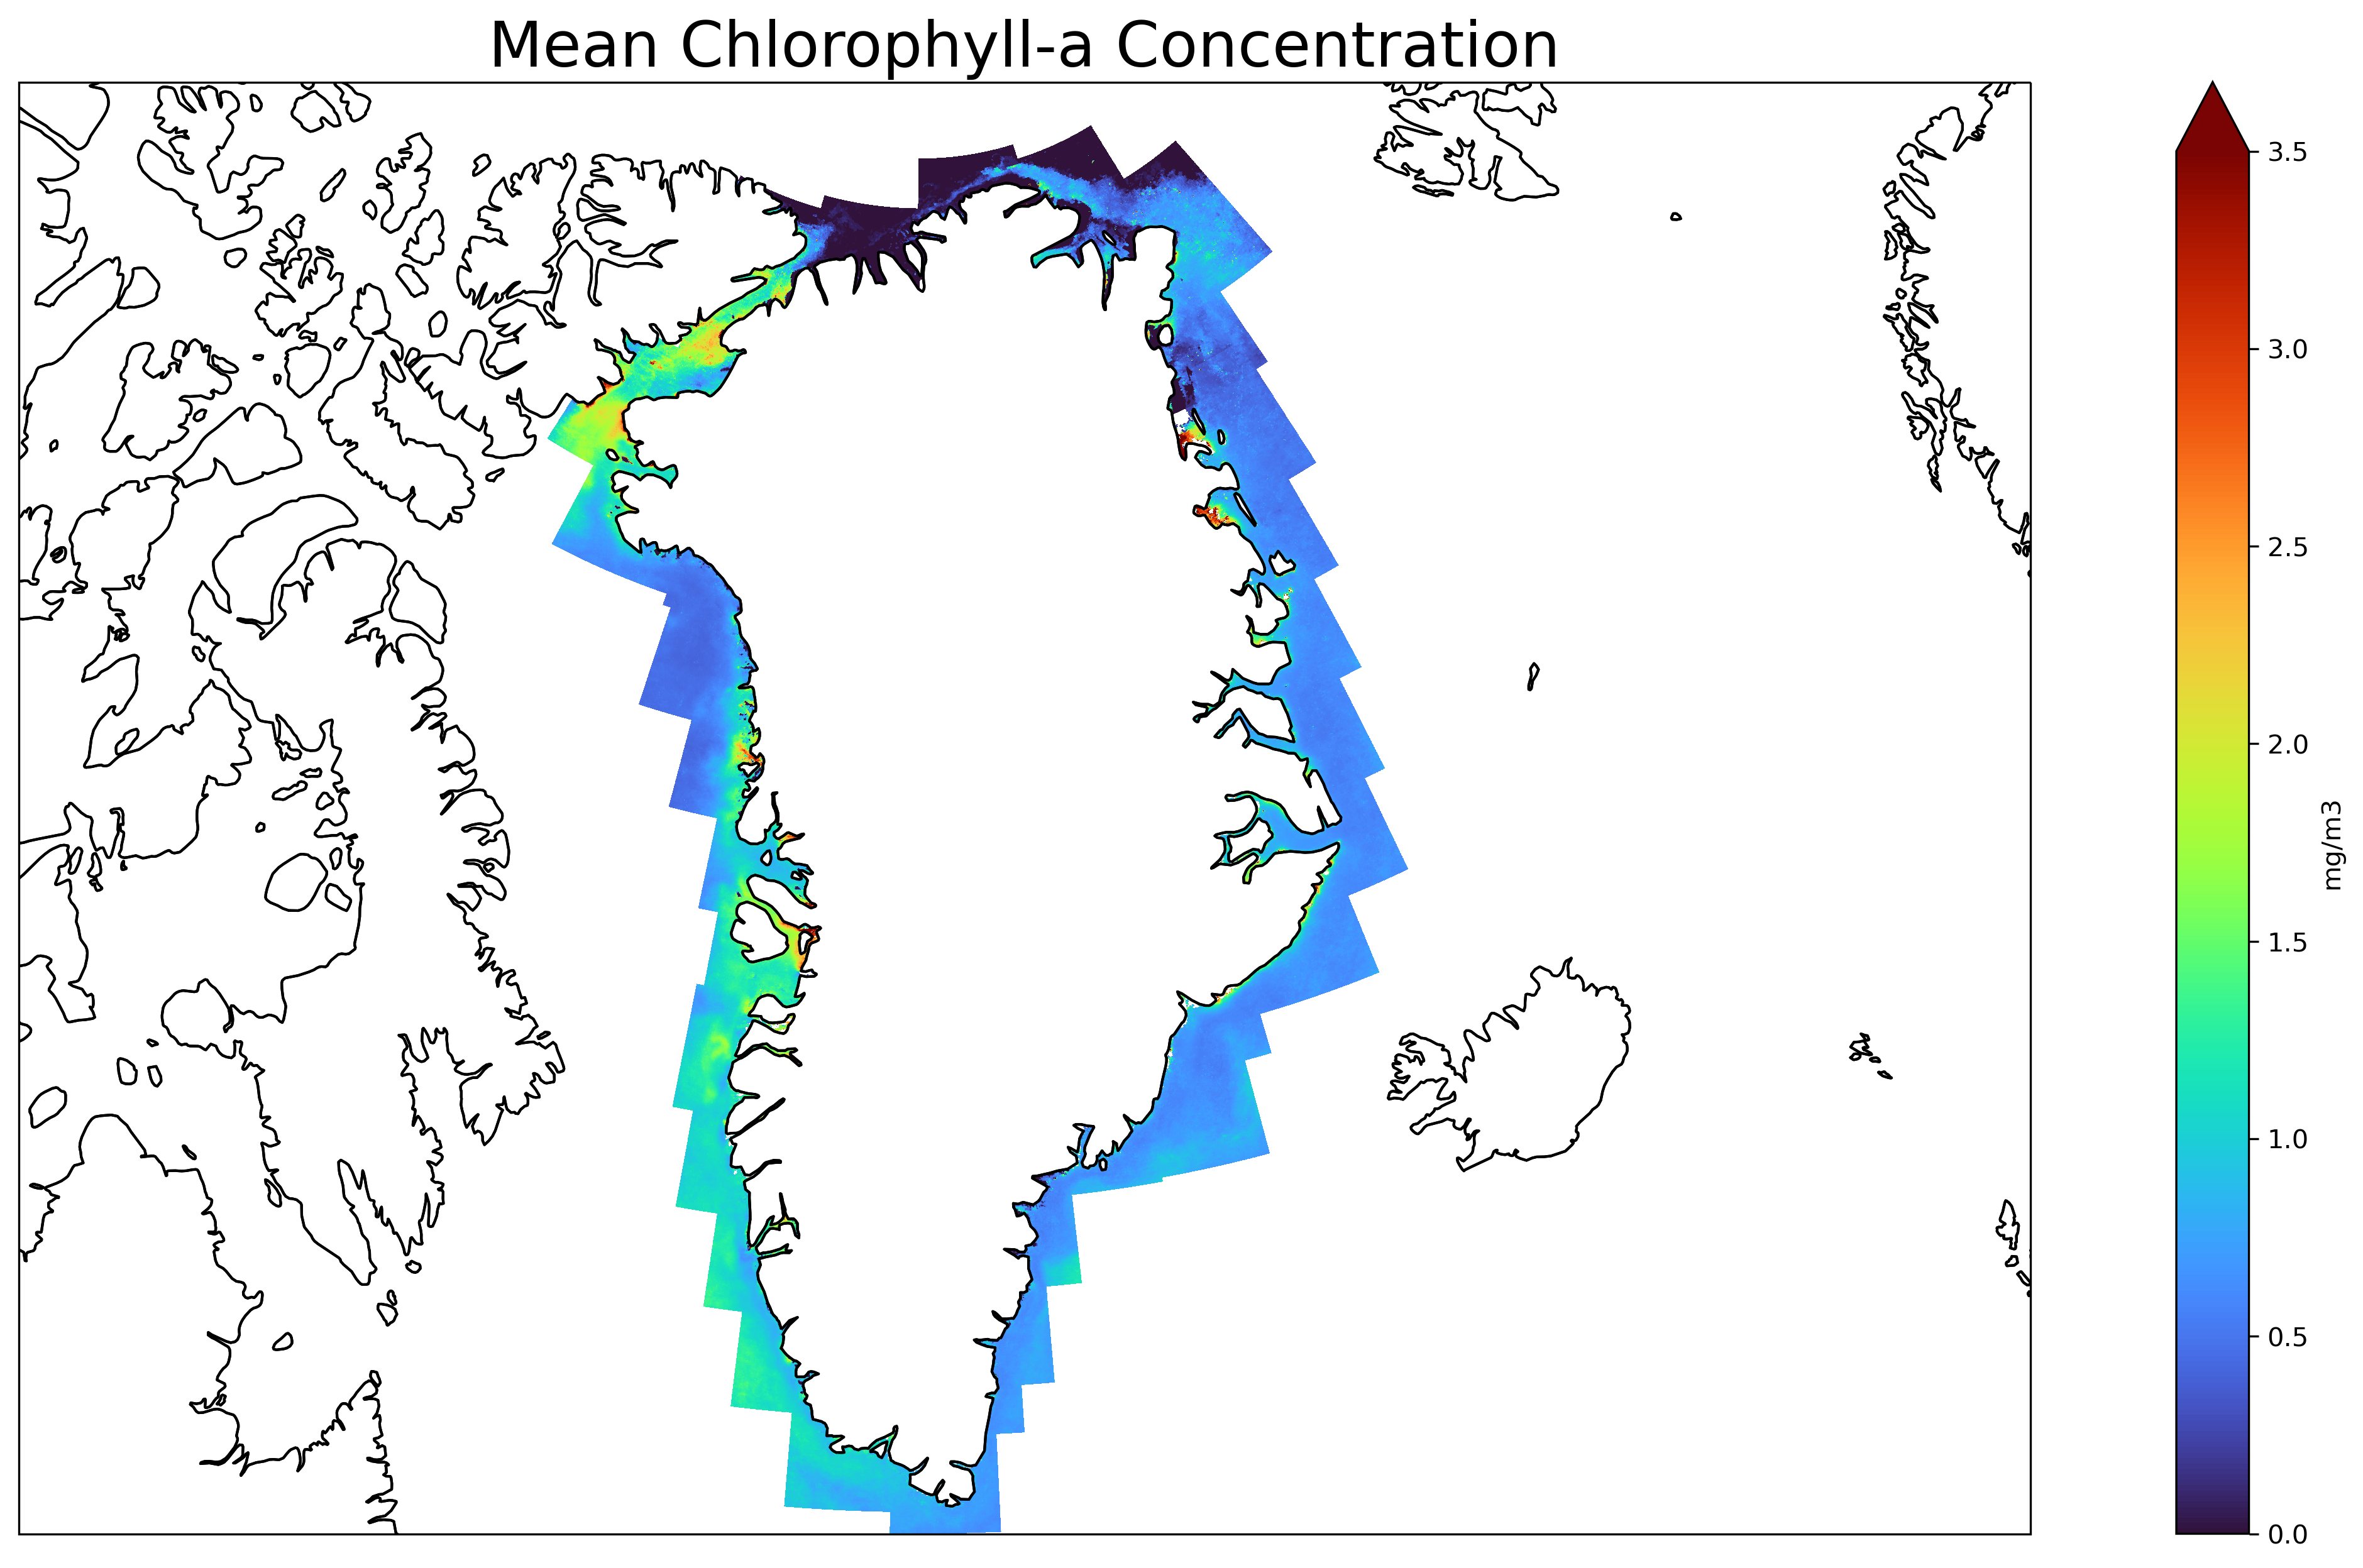

In [28]:
mean_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_mean_files'
ds = xr.open_dataset(os.path.join(mean_output, 'mean_weekly_all_regions.nc'))
# Compute the mean 'chlor_a' value for each pixel across all regions
mean_chlor_a = ds['chlor_a'].mean(dim='region')


plot_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_stats_maps/'
fig, ax = plt.subplots(figsize=(20, 10), dpi=300, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})

# Plot 'mean'
mean_chlor_a.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', cbar_kwargs={'label': 'mg/m3'}, vmin=0, vmax=3.5)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
ax.set_title('Mean Chlorophyll-a Concentration', fontsize=24)

plt.savefig(os.path.join(plot_output , f'mean_chlor_a.png'))

## Combine the slope and std err into a single pan GL file

In [33]:
stats_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_stats/'

# Initialize an empty list to store the datasets
datasets = []

# Loop over all regions
for region in range(0, 35):
    print(f"Working on region {region}")
    # Open the dataset for the current region
    ds = xr.open_dataset(os.path.join(stats_fp, f'trendline_weekly_region_{str(region).zfill(2)}.nc'))
    
    # Select the 'slope', 'numpts', and 'stderr' variables
    ds = ds[['slope', 'numpts', 'stderr']]
    
    # Add the dataset to the list
    datasets.append(ds)
    ds.close()

# Combine all datasets along the latitude and longitude dimensions
combined_ds = xr.concat(datasets, dim='region')

combined_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/'
combined_ds.to_netcdf(os.path.join(combined_fp, 'combined_trendline_weekly.nc'))

Working on region 0
Working on region 1
Working on region 2
Working on region 3
Working on region 4
Working on region 5
Working on region 6
Working on region 7
Working on region 8
Working on region 9
Working on region 10
Working on region 11
Working on region 12
Working on region 13
Working on region 14
Working on region 15
Working on region 16
Working on region 17
Working on region 18
Working on region 19
Working on region 20
Working on region 21
Working on region 22
Working on region 23
Working on region 24
Working on region 25
Working on region 26
Working on region 27
Working on region 28
Working on region 29
Working on region 30
Working on region 31
Working on region 32
Working on region 33
Working on region 34


## Plot the pan GL plots

In [13]:
# mean_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_mean_files'
# mean_ds = xr.open_dataset(os.path.join(mean_output, 'mean_weekly_all_regions.nc'))

plot_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/pangl_plots/'

# stats_fp = '/Volumes/Seagate 5TB/OceanColour Data/statistics/'
# stats_ds = xr.open_dataset(os.path.join(stats_fp, 'combined_trendline_weekly.nc'))

mean_output = '/Volumes/Seagate 5TB/OceanColour Data/statistics/regional_weekly_mean_files'
mean_ds = xr.open_dataset(os.path.join(mean_output, 'mean_weekly_all_regions.nc'))

fig, ax = plt.subplots(figsize=(20, 14), dpi=400, subplot_kw={'projection': ccrs.Stereographic(central_longitude=-45, central_latitude=90)})
# fig.suptitle(f"GL Stats", fontsize=42)

# # Plot 'mean'
mean_ds['chlor_a'].mean(dim='region').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', cbar_kwargs={'label': 'mg/m3', 'fraction': 0.036}, vmin=0, vmax=3.5)
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
ax.set_title('Mean Chlorophyll-a Concentration', fontsize=28)
plt.savefig(os.path.join(plot_output , f'mean.png'))

# # Plot 'slope'
# stats_ds = stats_ds[['slope']]
# stats_ds['slope'].mean(dim='region').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='seismic', cbar_kwargs={'label': 'mg/m3/week', 'fraction': 0.036}, vmin = -.0025, vmax = .0025)
# ax.coastlines()
# ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white') 
# ax.set_title('Chlorophyll-a Trend', fontsize=28)
# plt.savefig(os.path.join(plot_output , f'slope.png'))

# Plot 'numpts'
# stats_ds = stats_ds[['numpts']]
# stats_ds['numpts'].mean(dim='region').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', vmin = 0, vmax = 1000, cbar_kwargs={'label': 'Valid Points', 'fraction': 0.036})
# ax.coastlines()
# ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
# ax.set_title('Number of Data Points', fontsize=28)
# plt.savefig(os.path.join(plot_output , f'numpts.png'))

# # Plot 'stderr'
# stats_ds = stats_ds[['stderr']]
# stats_ds['stderr'].mean(dim='region').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Reds', cbar_kwargs={'label': 'mg/m3', 'fraction': 0.036}, vmin = 0, vmax = 1)
# ax.coastlines()
# ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='white')
# ax.set_title('Standard Error of the Trend', fontsize=28)
# plt.savefig(os.path.join(plot_output , f'stderr.png'))

plt.close()
stats_ds.close()
mean_ds.close()